<h3> PLayStore Data Sentiment Analysis

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [14]:
#import apps
apps_df=pd.read_csv("apps.csv")
apps_df

,Unnamed: 0,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9654,10836,Sya9a Maroc - FR,FAMILY,4.5,38,53M,"5,000+",Free,0,Everyone,Education,"July 25, 2017",1.48,4.1 and up
9655,10837,Fr. Mike Schmitz Audio Teachings,FAMILY,5.0,4,3.6M,100+,Free,0,Everyone,Education,"July 6, 2018",1.0,4.1 and up
9656,10838,Parkinson Exercices FR,MEDICAL,NaN,3,9.5M,"1,000+",Free,0,Everyone,Medical,"January 20, 2017",1.0,2.2 and up
9657,10839,The SCP Foundation DB fr nn5n,BOOKS_AND_REFERENCE,4.5,114,NaN,"1,000+",Free,0,Mature 17+,Books & Reference,"January 19, 2015",Varies with device,Varies with device


In [15]:
#import reviews
reviews_df=pd.read_csv('user_reviews.csv')
reviews_df

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000
...,...,...,...,...,...
64290,Houzz Interior Design Ideas,NaN,NaN,NaN,NaN
64291,Houzz Interior Design Ideas,NaN,NaN,NaN,NaN
64292,Houzz Interior Design Ideas,NaN,NaN,NaN,NaN
64293,Houzz Interior Design Ideas,NaN,NaN,NaN,NaN


In [16]:
apps_df.drop(columns=['Unnamed: 0'], inplace=True)
apps_df.drop_duplicates(inplace=True)

def clean_size(size):
    if isinstance(size, str):
        if 'M' in size:
            return float(size.replace('M', '')) * 1_000_000
        elif 'k' in size.lower():
            return float(size.lower().replace('k', '')) * 1_000
        elif size == 'Varies with device':
            return np.nan
    return np.nan

apps_df['Size'] = apps_df['Size'].apply(clean_size)
apps_df['Size'].fillna(apps_df['Size'].median(), inplace=True)
apps_df['Installs'] = apps_df['Installs'].str.replace(r'[+,]', '', regex=True).astype('Int64')
apps_df['Price'] = apps_df['Price'].replace('[\$]', '', regex=True).astype(float)
apps_df['Rating'] = pd.to_numeric(apps_df['Rating'], errors='coerce')
apps_df = apps_df[(apps_df['Rating'].isna()) | ((apps_df['Rating'] >= 1.0) & (apps_df['Rating'] <= 5.0))]

/var/folders/cm/9rjzvcbn783456m0cwxvszdh0000gn/T/ipykernel_4946/1581297607.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  apps_df['Size'].fillna(apps_df['Size'].median(), inplace=True)


In [17]:
# ----------------------- Clean Reviews Dataset ----------------------- #
reviews_df.dropna(subset=['Translated_Review', 'Sentiment'], inplace=True)
reviews_df.drop_duplicates(inplace=True)
reviews_df['Sentiment_Polarity'].fillna(reviews_df['Sentiment_Polarity'].mean(), inplace=True)
reviews_df['Sentiment_Subjectivity'].fillna(reviews_df['Sentiment_Subjectivity'].mean(), inplace=True)

/var/folders/cm/9rjzvcbn783456m0cwxvszdh0000gn/T/ipykernel_4946/1684368555.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  reviews_df['Sentiment_Polarity'].fillna(reviews_df['Sentiment_Polarity'].mean(), inplace=True)
/var/folders/cm/9rjzvcbn783456m0cwxvszdh0000gn/T/ipykernel_4946/1684368555.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediat

In [18]:

# ----------------------- Merge Datasets ----------------------- #
merged_df = pd.merge(reviews_df, apps_df, on='App', how='inner')

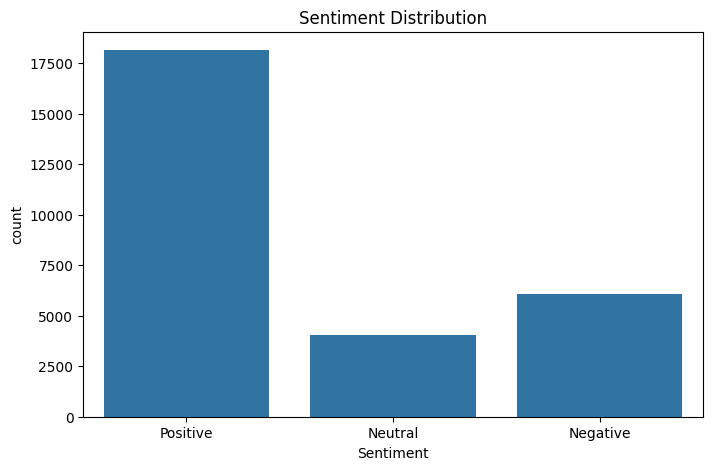

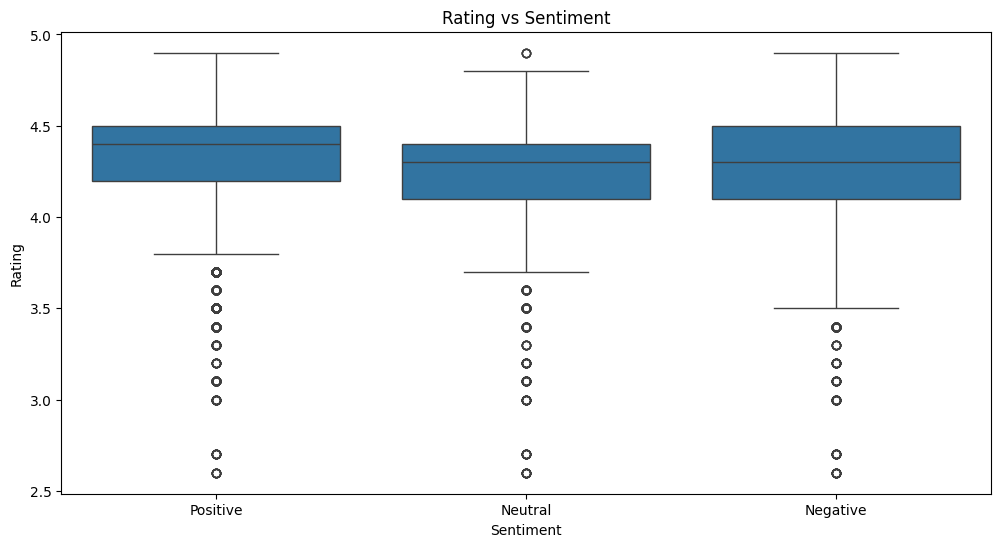

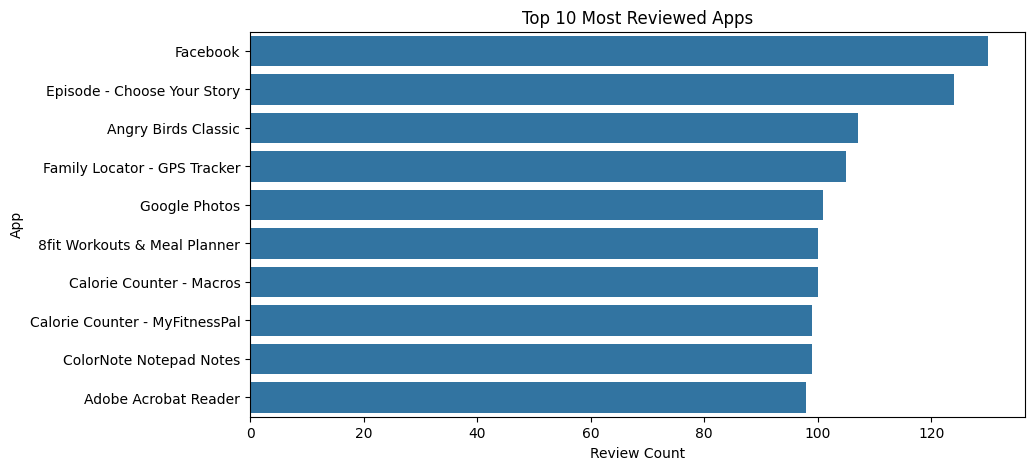

In [19]:

# ----------------------- Basic EDA Visualizations ----------------------- #
plt.figure(figsize=(8,5))
sns.countplot(data=merged_df, x='Sentiment')
plt.title("Sentiment Distribution")
plt.show()

plt.figure(figsize=(12,6))
sns.boxplot(data=merged_df, x='Sentiment', y='Rating')
plt.title("Rating vs Sentiment")
plt.show()

plt.figure(figsize=(10,5))
top_apps = merged_df['App'].value_counts().head(10)
sns.barplot(x=top_apps.values, y=top_apps.index)
plt.title("Top 10 Most Reviewed Apps")
plt.xlabel("Review Count")
plt.show()


In [20]:
# ----------------------- Text Preprocessing ----------------------- #
def clean_text(text):
    text = text.lower()
    text = re.sub(r"\d+", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = text.strip()
    return text

merged_df['clean_review'] = merged_df['Translated_Review'].apply(clean_text)

In [21]:

# ----------------------- TF-IDF Vectorization ----------------------- #
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(merged_df['clean_review'])


In [22]:

# ----------------------- Sentiment Label Encoding ----------------------- #
y = merged_df['Sentiment'].map({'Positive': 2, 'Neutral': 1, 'Negative': 0})



In [23]:
# ----------------------- Model Training ----------------------- #
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = MultinomialNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)



In [24]:

# ----------------------- Evaluation ----------------------- #
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=['Negative', 'Neutral', 'Positive']))


Accuracy: 0.7219469026548673
Confusion Matrix:
 [[ 401    8  773]
 [  23   55  710]
 [  48    9 3623]]
Classification Report:
               precision    recall  f1-score   support

    Negative       0.85      0.34      0.48      1182
     Neutral       0.76      0.07      0.13       788
    Positive       0.71      0.98      0.82      3680

    accuracy                           0.72      5650
   macro avg       0.77      0.46      0.48      5650
weighted avg       0.75      0.72      0.66      5650



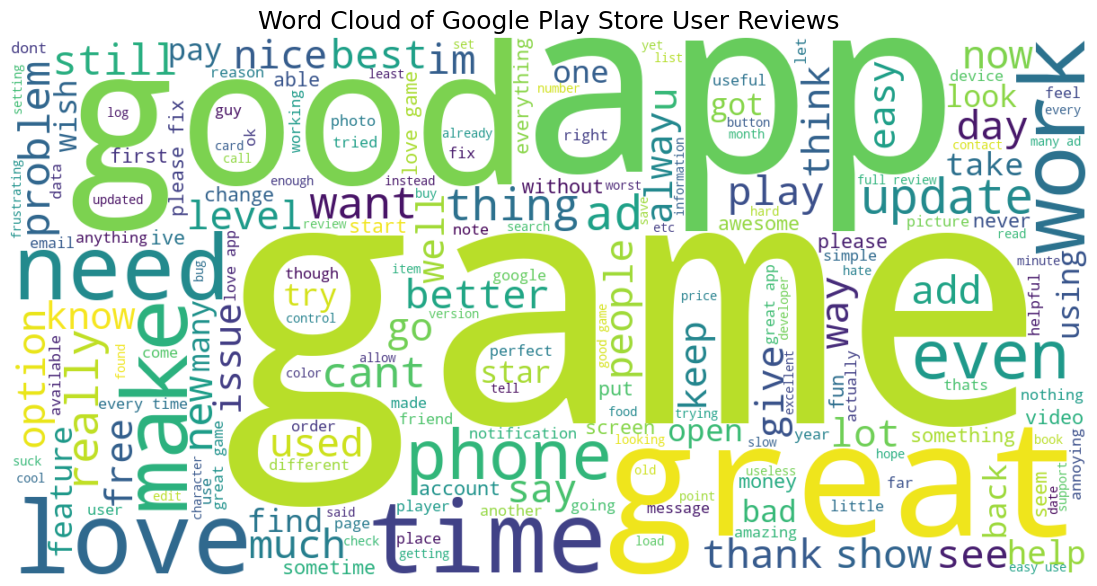

In [25]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
import re
import string

# Load your reviews dataset
reviews_df = pd.read_csv('user_reviews.csv')

# Drop NaNs and clean text
reviews_df = reviews_df.dropna(subset=['Translated_Review'])
text_data = reviews_df['Translated_Review']

# Clean the review text
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text.strip()

cleaned_reviews = text_data.apply(clean_text)

# Combine all reviews into a single string
all_text = ' '.join(cleaned_reviews)

# Generate word cloud
wordcloud = WordCloud(width=1200, height=600, background_color='white', colormap='viridis', max_words=200).generate(all_text)

# Plot
plt.figure(figsize=(14, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Google Play Store User Reviews", fontsize=18)
plt.show()
